# Fake News Project - Machine Learning

In [22]:
# imports
import pandas as pd
import re
import os
import multiprocess as mp
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Downloading NLTK resources
nltk.download("punkt")  # Standard tokenizer
nltk.download("stopwords")  # Common stopwords
nltk.download('punkt_tab')  # Specific requirement for your setup


[nltk_data] Downloading package punkt to /Users/Olga/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/Olga/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/Olga/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [23]:

# Load preprocessed dataset
df = pd.read_csv("995pre.csv")
print("Loaded 995pre.csv")
print(df[["binary_label"]].value_counts(normalize=True))

# Split into train/val/test (80/10/10) stratified by label
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df["binary_label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["binary_label"], random_state=42)

print(f" Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")


Loaded 995pre.csv
binary_label
0               0.758141
1               0.241859
Name: proportion, dtype: float64
 Train: 722942 | Val: 90368 | Test: 90368


## Part 2. Simple Logistic Regression Model.

Task 1

Training Logistic Regression...

 Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.97      0.94      0.95     68511
           1       0.83      0.91      0.86     21857

    accuracy                           0.93     90368
   macro avg       0.90      0.92      0.91     90368
weighted avg       0.93      0.93      0.93     90368



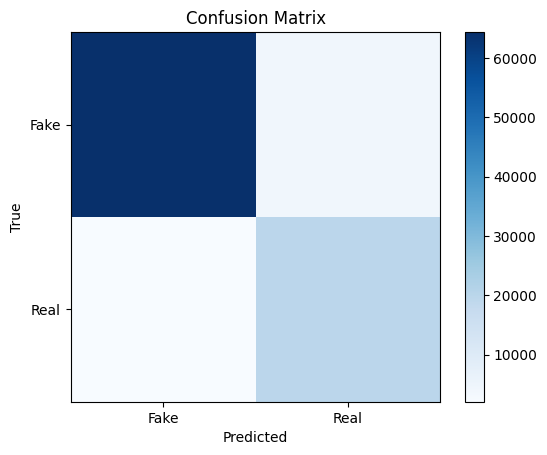

In [ ]:
# Prepare features and labels
X_train, y_train = train_df["text"], train_df["binary_label"]
X_val, y_val = val_df["text"], val_df["binary_label"]

# Build pipeline: CountVectorizer + Logistic Regression
pipeline = Pipeline([
    ("vect", CountVectorizer(max_features=10000)),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))

])

# Train the model
print("Training Logistic Regression...")
pipeline.fit(X_train, y_train)

# Evaluate on validation set
y_pred = pipeline.predict(X_val)

print("\n Classification Report (Validation Set):")
print(classification_report(y_val, y_pred))

# confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.xticks([0, 1], ["Fake", "Real"])
plt.yticks([0, 1], ["Fake", "Real"])
plt.show()

Task 2

Training Logistic Regression with metadata...

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     68511
           1       1.00      1.00      1.00     21857

    accuracy                           1.00     90368
   macro avg       1.00      1.00      1.00     90368
weighted avg       1.00      1.00      1.00     90368



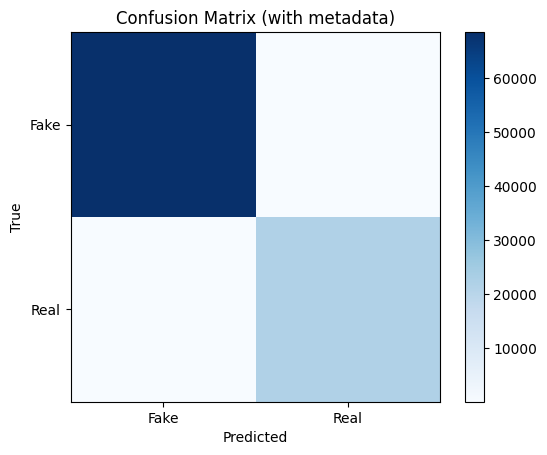

In [25]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Features to include
features = ["text", "authors", "domain", "source"]
target = "binary_label"

# Ensure X_train and X_val are DataFrames with all required columns
X_train = train_df[features].copy()
y_train = train_df[target]
X_val = val_df[features].copy()
y_val = val_df[target]

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("text", CountVectorizer(max_features=10000), "text"),
        ("authors", OneHotEncoder(handle_unknown="ignore"), ["authors"]),
        ("domain", OneHotEncoder(handle_unknown="ignore"), ["domain"]),
        ("source", OneHotEncoder(handle_unknown="ignore"), ["source"]),
    ]
)

# Full pipeline
pipeline_meta = Pipeline([
    ("preprocess", preprocessor),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

# Train
print("Training Logistic Regression with metadata...")
pipeline_meta.fit(X_train, y_train)

# Predict
y_pred = pipeline_meta.predict(X_val)

# Evaluate
print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_pred))

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix (with metadata)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.xticks([0, 1], ["Fake", "Real"])
plt.yticks([0, 1], ["Fake", "Real"])
plt.show()



In [26]:
# Just metadata: authors, domain, source
features_meta_only = ["authors", "domain", "source"]
X_train_meta = train_df[features_meta_only].copy()
X_val_meta = val_df[features_meta_only].copy()

# Pipeline without text
pipeline_meta_only = Pipeline([
    ("preprocess", ColumnTransformer([
        ("authors", OneHotEncoder(handle_unknown="ignore"), ["authors"]),
        ("domain", OneHotEncoder(handle_unknown="ignore"), ["domain"]),
        ("source", OneHotEncoder(handle_unknown="ignore"), ["source"]),
    ])),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

print("Training with metadata only...")
pipeline_meta_only.fit(X_train_meta, y_train)
y_pred_meta = pipeline_meta_only.predict(X_val_meta)

print("\nClassification Report (Metadata Only):")
print(classification_report(y_val, y_pred_meta))


Training with metadata only...

Classification Report (Metadata Only):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     68511
           1       1.00      1.00      1.00     21857

    accuracy                           1.00     90368
   macro avg       1.00      1.00      1.00     90368
weighted avg       1.00      1.00      1.00     90368



Task 3

Original training size: 722942, Extra data: 707, Combined: 723649
Cleaned training set size: 723566
Training Logistic Regression with extra data (cleaned)...

Classification Report (Validation Set, Augmented Data):
              precision    recall  f1-score   support

           0       0.97      0.94      0.95     68511
           1       0.83      0.91      0.86     21857

    accuracy                           0.93     90368
   macro avg       0.90      0.92      0.91     90368
weighted avg       0.93      0.93      0.93     90368



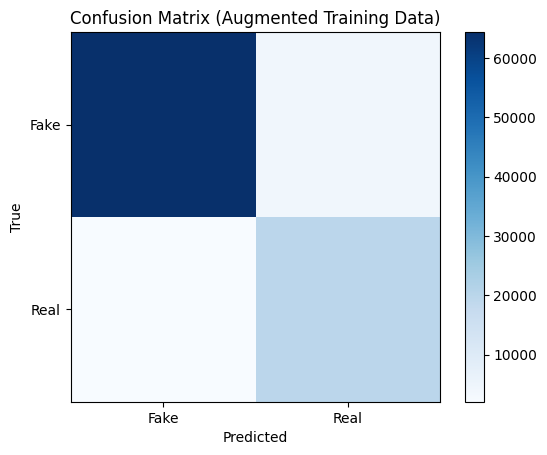

In [27]:
# Prepare features and labels
X_train, y_train = train_df["text"], train_df["binary_label"]
X_val, y_val = val_df["text"], val_df["binary_label"]

# Load cleaned additional data
df_extra = pd.read_csv("articles_full_pre.csv")

# Assign binary_label = 1 (trusted)
df_extra["binary_label"] = 1

# Combine with original training set
train_augmented = pd.concat([train_df, df_extra], ignore_index=True)
print(f"Original training size: {len(train_df)}, Extra data: {len(df_extra)}, Combined: {len(train_augmented)}")

# Drop rows with missing text
train_augmented_clean = train_augmented.dropna(subset=["text"])
print(f"Cleaned training set size: {len(train_augmented_clean)}")

# Prepare features and labels
X_train_aug = train_augmented_clean["text"]
y_train_aug = train_augmented_clean["binary_label"]

# Define pipeline
pipeline_aug = Pipeline([
    ("vect", CountVectorizer(max_features=10000)),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

# Train the model
print("Training Logistic Regression with extra data (cleaned)...")
pipeline_aug.fit(X_train_aug, y_train_aug)

# Evaluate on validation set
y_pred_aug = pipeline_aug.predict(X_val)

print("\nClassification Report (Validation Set, Augmented Data):")
print(classification_report(y_val, y_pred_aug))

# Confusion matrix
cm_aug = confusion_matrix(y_val, y_pred_aug)
plt.imshow(cm_aug, cmap="Blues")
plt.title("Confusion Matrix (Augmented Training Data)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.xticks([0, 1], ["Fake", "Real"])
plt.yticks([0, 1], ["Fake", "Real"])
plt.show()



## Part 3. Advanced Model

Training SVM with TF-IDF features...


/opt/homebrew/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 Classification Report (SVM, Validation Set):
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     68511
           1       0.84      0.92      0.88     21857

    accuracy                           0.94     90368
   macro avg       0.91      0.93      0.92     90368
weighted avg       0.94      0.94      0.94     90368



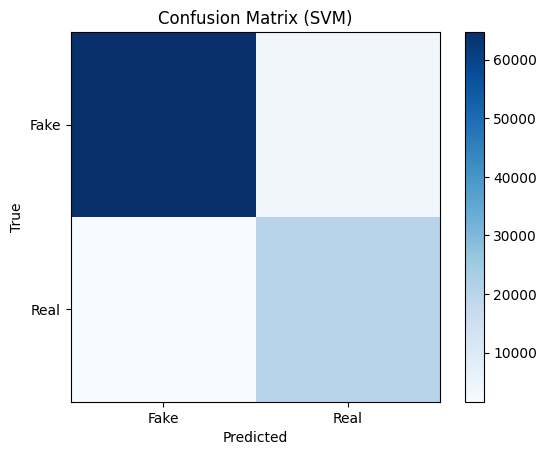

In [28]:
# Build pipeline: TF-IDF + SVM
svm_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=20000)),
    ("svm", LinearSVC(C=1.0, max_iter=1000, class_weight="balanced"))

])

# Train the SVM model
print("Training SVM with TF-IDF features...")
svm_pipeline.fit(X_train, y_train)

# Predict on validation set
y_pred_svm = svm_pipeline.predict(X_val)

# Classification report
print("\n Classification Report (SVM, Validation Set):")
print(classification_report(y_val, y_pred_svm))

# Confusion matrix
cm_svm = confusion_matrix(y_val, y_pred_svm)
plt.imshow(cm_svm, cmap="Blues")
plt.title("Confusion Matrix (SVM)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.xticks([0, 1], ["Fake", "Real"])
plt.yticks([0, 1], ["Fake", "Real"])
plt.show()

## Part 4. Evaluation

Task 1

In [29]:
# Prepare test data

test_df_clean = test_df.dropna(subset=["text"])
X_test, y_test = test_df_clean["text"], test_df_clean["binary_label"]

# Comparison

# Logistic Regression
y_pred_logreg_test = pipeline.predict(X_test)
print("\n Logistic Regression (Test Set):")
print(classification_report(y_test, y_pred_logreg_test))

# SVM
y_pred_svm_test = svm_pipeline.predict(X_test)
print("\n SVM (Test Set):")
print(classification_report(y_test, y_pred_svm_test))


 Logistic Regression (Test Set):
              precision    recall  f1-score   support

           0       0.97      0.94      0.96     68511
           1       0.83      0.91      0.87     21856

    accuracy                           0.93     90367
   macro avg       0.90      0.93      0.91     90367
weighted avg       0.94      0.93      0.93     90367


 SVM (Test Set):
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     68511
           1       0.84      0.93      0.88     21856

    accuracy                           0.94     90367
   macro avg       0.91      0.94      0.92     90367
weighted avg       0.94      0.94      0.94     90367



Tasks 2 and 3

 Loaded LIAR test set: 1267 samples
 Class balance - Real: 16.42%, Fake: 83.58%

 Logistic Regression on LIAR dataset:
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      1059
           1       0.25      0.01      0.02       208

    accuracy                           0.83      1267
   macro avg       0.54      0.50      0.46      1267
weighted avg       0.74      0.83      0.76      1267



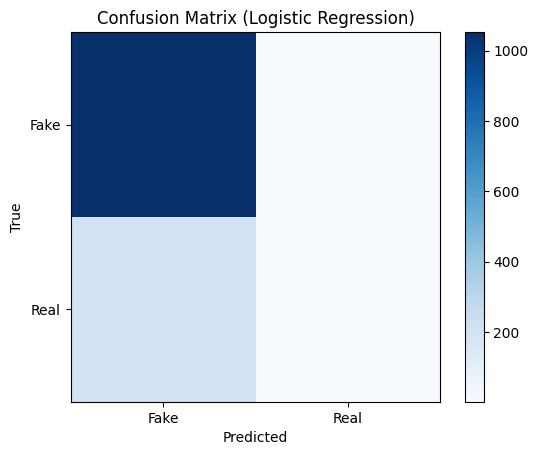


 SVM on LIAR dataset:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90      1059
           1       0.20      0.03      0.06       208

    accuracy                           0.82      1267
   macro avg       0.52      0.50      0.48      1267
weighted avg       0.73      0.82      0.76      1267



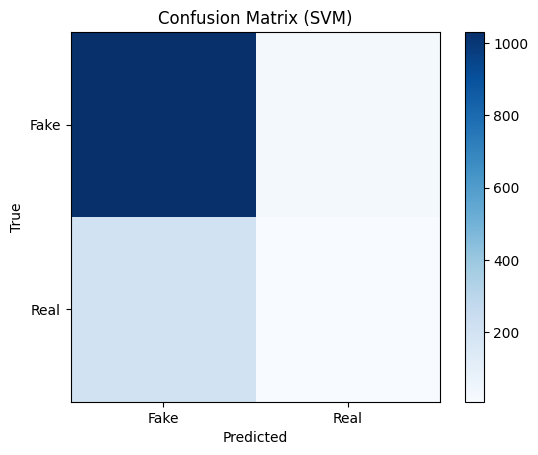

In [30]:
# Load LIAR test set
column_names = [
    "id", "label", "statement", "subject", "speaker", "speaker_job_title",
    "state_info", "party_affiliation", "barely_true_counts", "false_counts",
    "half_true_counts", "mostly_true_counts", "pants_on_fire_counts", "context"
]

liar_df = pd.read_csv("test.tsv", sep="\t", header=None, names=column_names)
print(f" Loaded LIAR test set: {liar_df.shape[0]} samples")

# Binary label mapping
real_labels = ["true"]
fake_labels = ["false", "barely-true", "pants-fire", "half-true", "mostly-true"]

liar_df["binary_label"] = liar_df["label"].apply(lambda x: 1 if x in real_labels else 0)
X_liar = liar_df["statement"]
y_liar = liar_df["binary_label"]
print(f" Class balance - Real: {y_liar.mean():.2%}, Fake: {(1 - y_liar.mean()):.2%}")

# Evaluate Logistic Regression pipeline
print("\n Logistic Regression on LIAR dataset:")
y_pred_logreg = pipeline.predict(X_liar)
print(classification_report(y_liar, y_pred_logreg))

cm_logreg = confusion_matrix(y_liar, y_pred_logreg)
plt.imshow(cm_logreg, cmap="Blues")
plt.title("Confusion Matrix (Logistic Regression)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.xticks([0, 1], ["Fake", "Real"])
plt.yticks([0, 1], ["Fake", "Real"])
plt.show()

# Evaluate SVM pipeline
print("\n SVM on LIAR dataset:")
y_pred_svm = svm_pipeline.predict(X_liar)
print(classification_report(y_liar, y_pred_svm))

cm_svm = confusion_matrix(y_liar, y_pred_svm)
plt.imshow(cm_svm, cmap="Blues")
plt.title("Confusion Matrix (SVM)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.xticks([0, 1], ["Fake", "Real"])
plt.yticks([0, 1], ["Fake", "Real"])
plt.show()